# 序列到序列模型（Seq2Seq）
Seq2Seq模型处理的问题是输入一个序列，输出一个序列的问题，输出输入词语之间经常没有一一对应关系，甚至长度也是不相等的。因此Seq2Seq模型索性使用两个RNN解决此问题——编码RNN（Encoder）负责处理输入但是不产生输出，而解码RNN（Decoder）接受编码RNN的最后一个隐藏层单元，并以此为唯一的根据产生需要的序列。

接下来我们设计一个非常简单的数据集，输入一个字符串（如“qwerty”），它的目标输出是它的相反字符串（如“ytrewq”）

In [1]:
# Define vocab, dataset and Dataloader
import random
import string
import torch

max_length = 5 # Max length of all sentences in this dataset
data_size = 20000 # Total numbers of data in this dataset
train_size = 18000 # Total numbers of train samples
batch_size = 128

vocab = list('-[]' + string.ascii_letters) # '-'=>PAD, ']'=>EOS, '['=>SOS
def str2tensor(x): return torch.tensor([vocab.index(w) for w in x]) # Converts string to tensor
def tensor2str(x): return "".join([vocab[int(i)] for i in x]) # Converts tensor to string
def get_randstr(l): return "".join([random.choice(string.ascii_letters) for i in range(l)]) # Return a random string

def get_loader(data_set, batch_size):
    """A generator yield data in dataset in batch"""
    for i in range(len(data_set) // batch_size):
        input = [data_set[j][0] for j in range(i*batch_size, min(len(data_set), (i+1)*batch_size))]
        output = [data_set[j][1] for j in range(i*batch_size, min(len(data_set), (i+1)*batch_size))]
        target = [data_set[j][2] for j in range(i*batch_size, min(len(data_set), (i+1)*batch_size))]
        yield input, output, target

def get_dataset(data_size, max_length=100, seed=0):
    data_set = []
    random.seed(seed)
    for i in range(data_size):
        seq = get_randstr(random.randint(1, max_length))
        data_set.append((
            str2tensor(seq), # Input term
            str2tensor("[" + "".join(reversed(seq))), # Output term
            str2tensor("".join(reversed(seq)) + "]"))) # Target output
    return data_set

data_set = get_dataset(data_size, max_length)
train_loader = list(get_loader(data_set[:train_size], batch_size))
dev_loader = list(get_loader(data_set[train_size:], batch_size))

## 不同RNN类型，隐藏层单元数对于网络表现的影响
我们使用了基本的三种循环神经网络（RNN（无门控），GRU，LSTM）在不同的隐藏层单元数的条件下，简单的检验它们对于序列的记忆能力的不同。每一项的左/中/右三个数据分别代表了RNN，GRU，LSTM在这个设定下的准确率百分比。模型类定义于model.py，训练函数定义于train.py
|       | h5       | h10      | h50      | h100      | h200      |
| ----- | -------- | -------- | -------- | --------- | --------- |
| len5  | 27/47/71 | 29/91/94 | 84/98/99 | 89/99/100 | 51/99/100 |
| len10 | 16/21/24 | 17/43/30 | 28/90/87 | 22/94/92  | 16/94/97  |
| len20 | 10/12/12 | 10/14/13 | 11/63/35 | 09/78/47  | 09/82/12  |
| len50 | 04/06/08 | 04/06/06 | 04/14/10 | 04/25/15  | 03/46/38  |

可以看到这些数据一些有意思的地方。整体上来看，隐藏层数量的增加对于提高网络对长序列的记忆能力是有帮助的，而且这种促进可能是非线性的（参考GRU在(5,10),(10,50),(20,200)有着相似的90%准确率，此时大致有$\text{len} \approx \sqrt{\text{2hidden}}$，由于RNN和LSTM工作不稳定这里不作为参考）。但是这种促进理论上至少应该是线性的，因为我们可以手工构建一个GRU(Encoder每次迭代都把隐藏层的前固定个元素移到隐藏层末尾，并向新的隐藏层头几个元素写入读取的数据，在Decoder层用同样的方式读取数据)来实现线性地把数据写进隐藏单元。

这中促进能力在RNN中表现的并不明显，尤其是在序列长度大于20以后，增大隐藏层单元数基本不能对准确率造成任何影响。这里的主要原因应该是数据处理的问题，我们使用了把长度小于最大长度的序列用“PAD”补齐到最大长度的方法来处理，这导致绝大多数的序列末尾都会有许多的占位符，这严重地影响了RNN对隐藏层数据的保持，而门控循环网络由于可以通过控制门来选择性的接受数据，它们不会受到太多的这类影响。

另一个有意思的现象是RNN在(5, 200)这个点准确率尤其低的问题，这打破了随着隐藏层数量增大，准确率提高的趋势。一开始我认为这是过拟合的现象，但是打印出训练准确率后发现其和测试准确率相差无几；经过一番尝试我发现，原来的1e-2学习速率在这里太大了，需要调小一些。看来在同一层参数量过大，应该适当调小一些学习数量。

整体上GRU和LSTM的表现相差无几，LSTM在隐藏层规模较大的区域也出现了准确度下降的情况，这和上面的原因应该是一致的，LSTM由于比GRU有更多的参数量可能需要更小学习速率。


In [16]:
# Train a GRU model with 64 hidden_units
from train import train, evaluate
from model import Seq2seq

# No printing, about 2 minutes to finish in itel i5 cpu
log_interval = 999999
num_epoches = 30
max_length = 15

# Set up train dataloader
data_set = get_dataset(data_size, max_length)
train_loader = list(get_loader(data_set[:train_size], batch_size))
dev_loader = list(get_loader(data_set[train_size:], batch_size))

# Training with GRU, 64 hidden_size
model = Seq2seq(vocab_size=len(vocab), hidden_size=64, core='GRU', bidirectional=False)
train(model, train_loader, num_epoches, log_interval)
print("Finish train with acc=%.2f" % (100 * evaluate(model, dev_loader)))

# The testing code used for generating the table above
# Don't run it unless you want to wait for a long time
# for core in ["RNN", "GRU", "LSTM"]:
#     for max_length in [5, 10, 20, 50]:
#         for hidden_size in [5, 10, 50, 100, 200]:
#             print("Start core=%s, len=%d, hidden=%d exp..." % (core, max_length, hidden_size))
#             data_set = get_dataset(data_size, max_length)
#             train_loader = list(get_loader(data_set[:train_size], batch_size))
#             dev_loader = list(get_loader(data_set[train_size:], batch_size))
#             model = Seq2seq(len(vocab), hidden_size, core=core, bidirectional=False)
#             train(model, train_loader, num_epoches, log_interval)
#             print(evaluate((model), train_loader))
#             print("Finish core=%s, len=%d, hidden=%d exp with acc=%.2f%" % (core, max_length, hidden_size, 100 * evaluate(model, dev_loader)))

100%|██████████| 15/15 [00:00<00:00, 62.00it/s]

Finish train with acc=90.35


In [7]:
# Testing our GRU model
seq_str = "HelloEveryOne"
input = str2tensor(seq_str).view((-1, 1))
output = model.predict(input, str2tensor("[").view((1, -1)), max_length+1) # torch.Size([max_length, 1, vocab_size])
output = output.argmax(dim=2).squeeze()
output_str = "".join([vocab[i] for i in list(output)])
print("In:  " + seq_str)
print("Out: " + output_str)

In:  HelloEveryOne
Out: enOyrevohlOtZR]]


## 使用Packed Sequence
之前看到RNN因为序列补齐长度所使用的\<PAD\>字符导致网络基本不能完成较长序列的记忆任务，这是我们所不想要的。但是不使用占位符我们也不能利用mini-batch的向量化运算了，这也是我们不想要的。那么有没有一种两全其美的解决方法呢？Pytorch为我们提供了一套解决方案，Pack_padded_sequence和Pad_packed_sequence。关于这两个函数的具体介绍可以看我的博客https://zhuanlan.zhihu.com/p/391815360。

如果不加任何改动，Pack_padded_sequence产生的PackedSequence对象只被nn.RNN等类接受，而Embedding等方法不接受PackedSequence对象。因此需要在model.py定义一个修改过的RNN类来实现这个要求。

可以看到，使用了PackedSequence的RNN马上就有了在长序列下和GRU，LSTM一绝雌雄的能力，同时训练速度也没有受到损害（如果不使用Mini-batch需要10分钟左右的时间，现在依然只需要20秒）。可以说这是一个双赢的局面。

In [2]:
# Train using PackRNN
from train import train, evaluate
from model import PackRNN

log_interval = 90
num_epoches = 13
max_length = 50

# Set up train dataloader
data_set = get_dataset(data_size, max_length)
train_loader = list(get_loader(data_set[:train_size], batch_size))
dev_loader = list(get_loader(data_set[train_size:], batch_size))

# Training with GRU, 64 hidden_size
model = PackRNN(vocab_size=len(vocab), hidden_size=50)
train(model, train_loader, num_epoches, log_interval, packed=True)
print("Finish train with acc=%.2f" % (100 * evaluate(model, dev_loader, packed=True)))

Epoch: 1	Step: 89	Loss=3.343	0m:1s (- 0m:24s)
Epoch: 2	Step: 89	Loss=1.484	0m:2s (- 0m:20s)
Epoch: 3	Step: 89	Loss=0.786	0m:4s (- 0m:18s)
Epoch: 4	Step: 89	Loss=0.545	0m:6s (- 0m:16s)
Epoch: 5	Step: 89	Loss=0.442	0m:8s (- 0m:14s)
Epoch: 6	Step: 89	Loss=0.374	0m:9s (- 0m:12s)
Epoch: 7	Step: 89	Loss=0.334	0m:11s (- 0m:11s)
Epoch: 8	Step: 89	Loss=0.307	0m:13s (- 0m:9s)
Epoch: 9	Step: 89	Loss=0.268	0m:14s (- 0m:7s)
Epoch: 10	Step: 89	Loss=0.248	0m:15s (- 0m:5s)
Epoch: 11	Step: 89	Loss=0.232	0m:17s (- 0m:3s)
Epoch: 12	Step: 89	Loss=0.223	0m:18s (- 0m:2s)
Epoch: 13	Step: 89	Loss=0.200	0m:19s (- 0m:0s)


100%|██████████| 15/15 [00:00<00:00, 139.77it/s]

Finish train with acc=89.82


# 使用Attention机制
虽然有了PackedSequence的RNN现在已经很好使，但是现在网络的表现依然严重依赖于中间隐藏层的容量。于是我们现在引入Attention机制来使得我们的网络可以不再需要把所有的信息都储存在中间隐藏层里。

<img src="https://image.panwenbo.icu/blog20210724174150.png" alt="blog20210529172930" style="zoom: 22%;" />

Attention机制其实就是，相较于原先的只把最后一个Encoder隐藏层单元输入Decoder，Attention方法把所有的Encoder隐藏层都输入Decoder。但是如果直接把它们拼接在一起并输入的话参数量就太大了，况且很多时候某一个Decoder时间刻只对一小部分的隐藏层感兴趣。Attention方法允许我们为每一个隐藏层都分配一个权重并把它们加权平均作为输入的Attention值。这个权重的计算方法有很多，每一个不同的Decoder时间刻都会独自地产生一套这时刻需要的权重，我们的权重计算函数因此同时需要一个Encoder隐藏层$h_i$和一个Decoder隐藏层$H_j$参与来确定在$H_j$眼里到底给$h_i$多少的权重，这里的计算方式我们采用缩放点积模型（其实也实现了其他方法）
$$
e_{ij} = \text{score}(h_i, H_j) = \frac{h_i^T H_j}{\sqrt{d_H}}
$$
计算完成的分数还要输入SoftMax构成真正的权重。关于Attention机制的详细介绍可以看我的详细全解https://zhuanlan.zhihu.com/p/
380892265
下面展示了这个Attention网络的基本示意图，这里我们只把Attention值输入最后的全连接层，当然也有着把Attention值输入循环神经网络的做法（参考https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html）。但是就现在这个问题而言使用前者是可行的并且有助于我们使用向量化的计算方法计算Attention值。

<img src="https://image.panwenbo.icu/blog20210725101134.png" alt="截屏2021-07-25 上午10.11.21" style="zoom:35%;" />

In [2]:
# Train using Seq2seq with attention
from train import train, evaluate
from model import Seq2seqAtt

log_interval = 90
num_epoches = 13
max_length = 20

# Set up train dataloader
data_set = get_dataset(data_size, max_length)
train_loader = list(get_loader(data_set[:train_size], batch_size))
dev_loader = list(get_loader(data_set[train_size:], batch_size))

# Training with GRU, 64 hidden_size
model = Seq2seqAtt(vocab_size=len(vocab), hidden_size=50)
train(model, train_loader, num_epoches, log_interval)
print("Finish train with acc=%.2f" % (100 * evaluate(model, dev_loader)))

Epoch: 1	Step: 89	Loss=2.210	0m:2s (- 0m:43s)
Epoch: 2	Step: 89	Loss=2.066	0m:6s (- 0m:42s)
Epoch: 3	Step: 89	Loss=1.809	0m:9s (- 0m:37s)
Epoch: 4	Step: 89	Loss=0.741	0m:12s (- 0m:33s)
Epoch: 5	Step: 89	Loss=0.082	0m:16s (- 0m:29s)
Epoch: 6	Step: 89	Loss=0.053	0m:19s (- 0m:25s)
Epoch: 7	Step: 89	Loss=0.042	0m:23s (- 0m:22s)
Epoch: 8	Step: 89	Loss=0.051	0m:27s (- 0m:19s)
Epoch: 9	Step: 89	Loss=0.044	0m:31s (- 0m:15s)
Epoch: 10	Step: 89	Loss=0.040	0m:35s (- 0m:12s)
Epoch: 11	Step: 89	Loss=0.113	0m:39s (- 0m:8s)
Epoch: 12	Step: 89	Loss=0.055	0m:43s (- 0m:5s)
Epoch: 13	Step: 89	Loss=0.036	0m:46s (- 0m:1s)


100%|██████████| 15/15 [00:00<00:00, 63.65it/s]

Finish train with acc=99.02


## 总结
可以看到有了Attention加持的RNN异常的生猛，虽然训练时间长了不少（最大长度为20情况下9s/50s，最大长度为50情况下37s/177s）。对于最大长度50，隐藏层单元数50情况下，在RNN，GRU，LSTM分别达到4%/14%/10%的准确率时，带有Attention的RNN达到了77%的准确率。在最大长度20，隐藏层单元数50的情况下达到了99的准确率，这时我们打印出某一个batch中的所有Attention值，可以看到非常明显的对角线纹理。

<img src="https://image.panwenbo.icu/blog20210725133247.png" alt="c2eec157-16cb-4924-8157-3cfc46e07c42" style="zoom:67%;" />


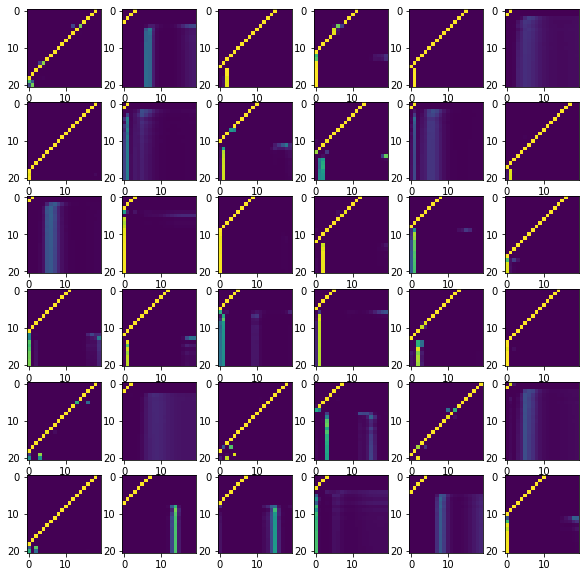

In [14]:
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence

input, output, target = dev_loader[0]
input = pad_sequence(input)
output = pad_sequence(output)

att_weights = model(input, output, return_att=True)
att_weights = att_weights.detach().numpy()
plt.figure(figsize=(10,10))
for i in range(1, 37):
    plt.subplot(6, 6, i)
    plt.imshow(att_weights[:, :, i])
plt.show()